## ANN-4 vs Heston Monte Carlo Model

In [ ]:
# public modules 
import numpy as np
from tensorflow import keras
import tensorflow as tf

In [ ]:
# check to see if GPU is in use

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# connection to google drive + import data

import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/content")

data = np.genfromtxt('heston_data.csv', delimiter=',')

# inputs: converting spot price + strike price to moneyness (s/k)
inputs = data[:,:9] 
X = np.array([np.array([x[0]/x[1], x[2],x[3],x[4], x[5], x[6], x[7], x[8]])for x in inputs])

# outputs: scaling the prices byt the strike price (p/k)
y_calls = np.array(data[:,-2]) / data[:,1]
y_puts = np.array(data[:,-1]) / data[:,1]

X_train = X[:150000]
y_calls_train = y_calls[:150000]
y_puts_train = y_puts[:150000]

X_val = X[150000:175000]
y_calls_val = y_calls[150000:175000]
y_puts_val = y_puts[150000:175000]

X_test = X[175000:]
y_calls_test = y_calls[175000:]
y_puts_test = y_puts[175000:]


print(X_train.shape)
print(y_calls_train.shape)
print(y_puts_train.shape)
print(X_val.shape)
print(y_calls_val.shape)
print(y_puts_val.shape)
print(X_test.shape)
print(y_calls_test.shape)
print(y_puts_test.shape)

Mounted at /content/drive
(150000, 8)
(150000,)
(150000,)
(25000, 8)
(25000,)
(25000,)
(25000, 8)
(25000,)
(25000,)


In [ ]:
# loading ANN-4
ann_4 = keras.models.load_model('ANN-4')

In [ ]:
# mse check
print('Evaluating...')
ann_4_mse = ann_4.evaluate(X_test, [y_calls_test,y_puts_test])
ann_4_mse_call = ann_4_mse[1]
ann_4_mse_put = ann_4_mse[2]
print('\n')

print('ANN-4 achieves an average MSE of ' + str(ann_4_mse_call) + ' for call options')
print('ANN-4 achieves an average MSE of ' + str(ann_4_mse_put) + ' for put options')

Evaluating...
782/782 [==============================] - 4s 2ms/step - loss: 2.6661e-05 - call_output_loss: 1.3793e-05 - put_output_loss: 1.2868e-05


ANN-4 achieves an average MSE of 1.3792619938612916e-05 for call options
ANN-4 achieves an average MSE of 1.2868355952377897e-05 for put options


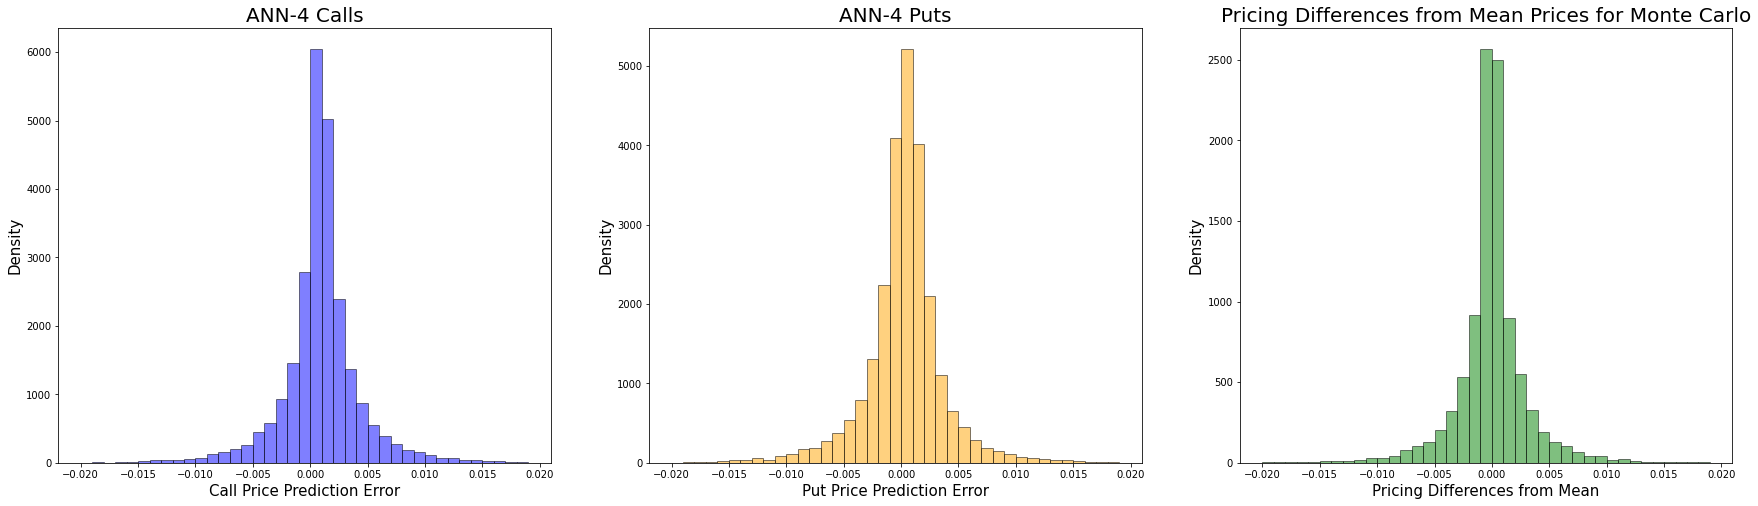

In [ ]:
# error inspection + avg pricing differences when using classical Monte Carlo method

ann_4_predictions = ann_4.predict(X_test)
ann_4_put_preds = ann_4_predictions[1].flatten()
ann_4_put_preds = [0 if put < 0 else put for put in ann_4_put_preds]
ann_4_call_preds = ann_4_predictions[0].flatten()
ann_4_call_preds = [0 if call < 0 else call for call in ann_4_call_preds]
ann_4_call_errors = np.subtract(y_calls_test, ann_4_call_preds)
ann_4_put_errors = np.subtract(y_puts_test, ann_4_put_preds)

ten_sample_prices = np.genfromtxt('heston_thousand_samples_with_ten_prices.csv', delimiter=',')
differences_from_mean_price = []
for sample in ten_sample_prices:
  sample_mean = sum(sample) / len(sample)
  for price in sample:
    diff = price - sample_mean
    differences_from_mean_price.append(diff)


import matplotlib.pyplot as plt

bins = np.arange (-0.02, 0.02, 0.001)
fig, axs = plt.subplots(1,3)
fig.set_figheight(8)
fig.set_figwidth(30)

axs[0].hist(ann_4_call_errors,bins, ec='black', color='blue', alpha=0.5)
axs[0].set_title('ANN-4 Calls', fontsize=20)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('Call Price Prediction Error', fontsize=15)
axs[1].hist(ann_4_put_errors,bins, ec='black', color='orange', alpha=0.5)
axs[1].set_title('ANN-4 Puts', fontsize=20)
axs[1].set_ylabel('Density', fontsize=15)
axs[1].set_xlabel('Put Price Prediction Error', fontsize=15)
axs[2].hist(differences_from_mean_price, bins, ec='black', color='green', alpha=0.5)
axs[2].set_title('Pricing Differences from Mean Prices for Monte Carlo', fontsize=20)
axs[2].set_ylabel('Density', fontsize=15)
axs[2].set_xlabel('Pricing Differences from Mean', fontsize=15)

fig.savefig('ann_4_errors.png')

## Error Distribution Inspection

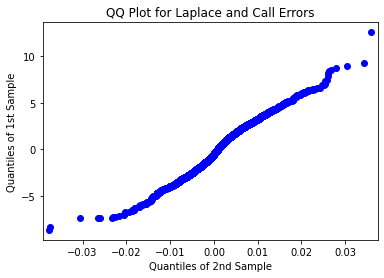

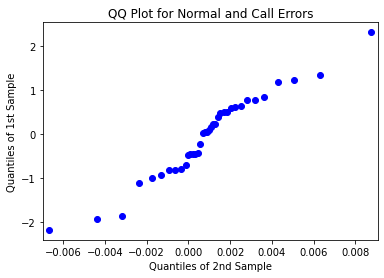

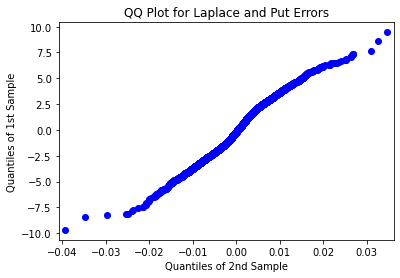

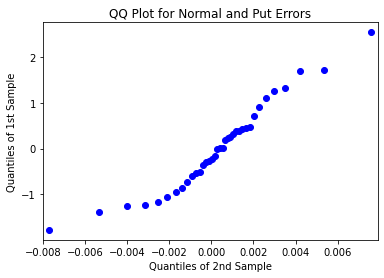

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

# Laplace distribution QQ-plot FOR CALLS
loc, scale = 0,1
s = np.random.default_rng().laplace(loc, scale, 25000)
pp_x = sm.ProbPlot(s)
pp_y = sm.ProbPlot(ann_4_call_errors)

qqplot_2samples(pp_x, pp_y)
plt.title('QQ Plot for Laplace and Call Errors')
plt.show()

# Normal distribution QQ-plot FOR CALLS
s = np.random.normal(loc=loc, scale=scale, size=37)
pp_x = sm.ProbPlot(s)
pp_y = sm.ProbPlot(ann_4_call_errors)

qqplot_2samples(pp_x, pp_y)
plt.title('QQ Plot for Normal and Call Errors')
plt.show()


# Laplace distribution QQ-plot FOR PUTS
loc, scale = 0,1
s = np.random.default_rng().laplace(loc, scale, 25000)
pp_x = sm.ProbPlot(s)
pp_y = sm.ProbPlot(ann_4_put_errors)

qqplot_2samples(pp_x, pp_y)
plt.title('QQ Plot for Laplace and Put Errors')
plt.show()

# Normal distribution QQ-plot FOR PUTS
s = np.random.normal(loc=loc, scale=scale, size=37)
pp_x = sm.ProbPlot(s)
pp_y = sm.ProbPlot(ann_4_put_errors)

qqplot_2samples(pp_x, pp_y)
plt.title('QQ Plot for Normal and Put Errors')
plt.show()

## Unscaled Option Prices

In [ ]:
rescaled_ann_4_call_preds = ann_4_call_preds * data[-25000:,1]
rescaled_ann_4_put_preds = ann_4_put_preds * data[-25000:,1]

rescaled_differences_ann_4_call = data[-25000:, -2] - rescaled_ann_4_call_preds
rescaled_differences_ann_4_put = data[-25000:, -1] - rescaled_ann_4_put_preds

In [ ]:
moneyness = X[-25000:,0]
ann_4_call_moneyness, ann_4_call_moneyness_errors = zip(*sorted(zip(moneyness,rescaled_differences_ann_4_call)))
ann_4_put_moneyness, ann_4_put_moneyness_errors = zip(*sorted(zip(moneyness,rescaled_differences_ann_4_put)))

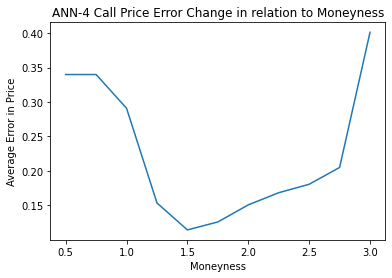

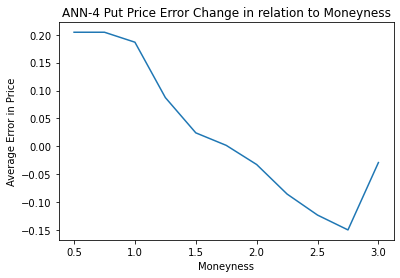

In [ ]:
import statistics
averaging_bins = np.arange(0.5,3.25,0.25)

ann_4_call_list_to_hold_averages = []
ann_4_put_list_to_hold_averages = []

for j in range(len(averaging_bins)):
  if averaging_bins[j] == 0.5:
    pass
  else:
    bin_list = []
    for i in range(len(ann_4_call_moneyness)):
      if ann_4_call_moneyness[i] > averaging_bins[j-1] and ann_4_call_moneyness[i] <= averaging_bins[j]:
        bin_list.append(ann_4_call_moneyness_errors[i])
    average = statistics.mean(bin_list)
    ann_4_call_list_to_hold_averages.append(average)
    if averaging_bins[j] == 0.75:
      ann_4_call_list_to_hold_averages.append(average)

for j in range(len(averaging_bins)):
  if averaging_bins[j] == 0.5:
    pass
  else:
    bin_list = []
    for i in range(len(ann_4_call_moneyness)):
      if ann_4_put_moneyness[i] > averaging_bins[j-1] and ann_4_put_moneyness[i] <= averaging_bins[j]:
        bin_list.append(ann_4_put_moneyness_errors[i])
    average = statistics.mean(bin_list)
    ann_4_put_list_to_hold_averages.append(average)
    if averaging_bins[j] == 0.75:
      ann_4_put_list_to_hold_averages.append(average)

plt.plot(averaging_bins, ann_4_call_list_to_hold_averages)
plt.title('ANN-4 Call Price Error Change in relation to Moneyness')
plt.ylabel('Average Error in Price')
plt.xlabel('Moneyness')
plt.show()

plt.plot(averaging_bins, ann_4_put_list_to_hold_averages)
plt.title('ANN-4 Put Price Error Change in relation to Moneyness')
plt.ylabel('Average Error in Price')
plt.xlabel('Moneyness')
plt.show()

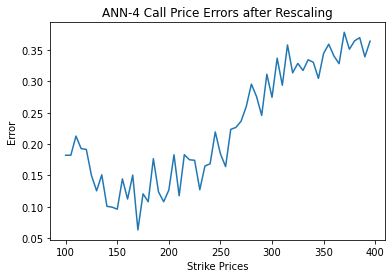

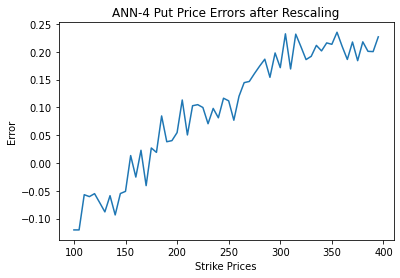

In [ ]:
# Average error according to strike price


strikes_list = data[-25000:,1]
# rescaled_differences_ann_1_call
bins_for_strikes = np.arange(100,400,5)

ann_4_call_list_to_hold_raw_errors = []
ann_4_put_list_to_hold_raw_errors = []

for i in range(len(bins_for_strikes)):
  if bins_for_strikes[i] == 100:
    pass
  else:
    list_for_aggregation = []
    for j in range(len(strikes_list)):
      if strikes_list[j] > bins_for_strikes[i-1] and strikes_list[j] <= bins_for_strikes[i]:
        list_for_aggregation.append(rescaled_differences_ann_4_call[j])
    average = statistics.mean(list_for_aggregation)
    ann_4_call_list_to_hold_raw_errors.append(average)
    if bins_for_strikes[i] == 105:
      ann_4_call_list_to_hold_raw_errors.append(average)

for i in range(len(bins_for_strikes)):
  if bins_for_strikes[i] == 100:
    pass
  else:
    list_for_aggregation = []
    for j in range(len(strikes_list)):
      if strikes_list[j] > bins_for_strikes[i-1] and strikes_list[j] <= bins_for_strikes[i]:
        list_for_aggregation.append(rescaled_differences_ann_4_put[j])
    average = statistics.mean(list_for_aggregation)
    ann_4_put_list_to_hold_raw_errors.append(average)
    if bins_for_strikes[i] == 105:
      ann_4_put_list_to_hold_raw_errors.append(average)


plt.plot(bins_for_strikes, ann_4_call_list_to_hold_raw_errors)
plt.title('ANN-4 Call Price Errors after Rescaling')
plt.ylabel('Error')
plt.xlabel('Strike Prices')
plt.show()

plt.plot(bins_for_strikes, ann_4_put_list_to_hold_raw_errors)
plt.title('ANN-4 Put Price Errors after Rescaling')
plt.ylabel('Error')
plt.xlabel('Strike Prices')
plt.show()

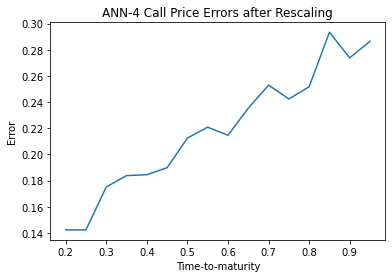

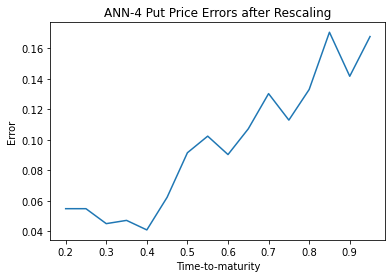

In [ ]:
# Average error according to volatility level
vol_list = data[-25000:,3]

# rescaled_differences_ann_1_call
bins_for_vol = np.arange(0.2,1,0.05)

ann_4_call_list_to_hold_raw_errors2 = []
ann_4_put_list_to_hold_raw_errors2 = []

for i in range(len(bins_for_vol)):
  if bins_for_vol[i] == 0.2:
    pass
  else:
    list_for_aggregation = []
    for j in range(len(vol_list)):
      if vol_list[j] > bins_for_vol[i-1] and vol_list[j] <= bins_for_vol[i]:
        list_for_aggregation.append(rescaled_differences_ann_4_call[j])
    average = statistics.mean(list_for_aggregation)
    ann_4_call_list_to_hold_raw_errors2.append(average)
    if bins_for_vol[i] == 0.25:
      ann_4_call_list_to_hold_raw_errors2.append(average)

for i in range(len(bins_for_vol)):
  if bins_for_vol[i] == 0.2:
    pass
  else:
    list_for_aggregation = []
    for j in range(len(vol_list)):
      if vol_list[j] > bins_for_vol[i-1] and vol_list[j] <= bins_for_vol[i]:
        list_for_aggregation.append(rescaled_differences_ann_4_put[j])
    average = statistics.mean(list_for_aggregation)
    ann_4_put_list_to_hold_raw_errors2.append(average)
    if bins_for_vol[i] == 0.25:
      ann_4_put_list_to_hold_raw_errors2.append(average)

plt.plot(bins_for_vol, ann_4_call_list_to_hold_raw_errors2)
plt.title('ANN-4 Call Price Errors after Rescaling')
plt.ylabel('Error')
plt.xlabel('Time-to-maturity')
plt.show()

plt.plot(bins_for_vol, ann_4_put_list_to_hold_raw_errors2)
plt.title('ANN-4 Put Price Errors after Rescaling')
plt.ylabel('Error')
plt.xlabel('Time-to-maturity')
plt.show()


## Speed Comparison

In [ ]:
from monte_carlo_class import MonteCarloOptionPricing
import time

# For 1 price valuation
one_prediction_ann_4 = 0
one_prediction_MC = 0

for i in range(10):
  start_time = time.time()
  ann_4_predictions = ann_4.predict(np.array([X_test[0]]))
  ann_4_put_preds = ann_4_predictions[1].flatten()
  ann_4_put_preds = np.multiply([0 if put < 0 else put for put in ann_4_put_preds], data[-25000,1])
  ann_4_call_preds = ann_4_predictions[0].flatten()
  ann_4_call_preds = np.multiply([0 if call < 0 else call for call in ann_4_call_preds], data[-25000,1])
  ann_4_time = (time.time() - start_time)
  one_prediction_ann_4 += ann_4_time

  start_time = time.time()
  MC = MonteCarloOptionPricing(S0 = inputs[-25000][0],
                                      K = inputs[-25000][1],
                                      T = inputs[-25000][3],
                                      r = inputs[-25000][2],
                                      sigma = inputs[-25000][4],
                                      div_yield = 0,
                                      simulation_rounds = 10000,
                                      no_of_slices = 40,
                                      fix_random_seed = False)

  MC.heston(kappa= inputs[-25000][7],
            theta = inputs[-25000][6],
            sigma_v = inputs[-25000][5],
            rho = inputs[-25000][8])

  MC.stock_price_simulation()


  call_price = MC.european_call() 
  put_price = MC.european_put(call_price)
  mc_time = (time.time() - start_time)
  one_prediction_MC += mc_time


print("ANN-4 took " + str(one_prediction_ann_4 / 10) + " seconds on average to price a call and put")
print("Monte Carlo took " + str(one_prediction_MC / 10) + " seconds on average to price a call and put")

ANN-4 took 0.05128018856048584 seconds on average to price a call and put
Monte Carlo took 0.10202515125274658 seconds on average to price a call and put


In [ ]:
# For 10 price valuations
ten_prediction_ann_4 = 0
ten_prediction_MC = 0
for i in range(10):
  start_time = time.time()
  ann_4_predictions = ann_4.predict(X_test[:10])
  ann_4_put_preds = ann_4_predictions[1].flatten()
  ann_4_put_preds = np.multiply([0 if put < 0 else put for put in ann_4_put_preds], data[-25000:-24990,1])
  ann_4_call_preds = ann_4_predictions[0].flatten()
  ann_4_call_preds = np.multiply([0 if call < 0 else call for call in ann_4_call_preds], data[-25000:-24990,1])
  ann_4_time = (time.time() - start_time)
  ten_prediction_ann_4 += ann_4_time

  start_time = time.time()
  for i in range(10):
    MC = MonteCarloOptionPricing(S0 = inputs[-25000 + i][0],
                                        K = inputs[-25000 + i][1],
                                        T = inputs[-25000 + i][3],
                                        r = inputs[-25000 + i][2],
                                        sigma = inputs[-25000 + i][4],
                                        div_yield = 0,
                                        simulation_rounds = 10000,
                                        no_of_slices = 40,
                                        fix_random_seed = False)

    MC.heston(kappa= inputs[-25000 + i][7],
              theta = inputs[-25000 + i][6],
              sigma_v = inputs[-25000 + i][5],
              rho = inputs[-25000 + i][8])

    MC.stock_price_simulation()


    call_price = MC.european_call() 
    put_price = MC.european_put(call_price)
  mc_time = (time.time() - start_time)
  ten_prediction_MC += mc_time


print("ANN-4 took " + str(ten_prediction_ann_4 / 10) + " seconds on average to price 10 calls and puts")
print("Monte Carlo took " + str(ten_prediction_MC / 10) + " seconds on average to price 10 calls and puts")

ANN-4 took 0.05051724910736084 seconds on average to price 10 calls and puts
Monte Carlo took 1.110764980316162 seconds on average to price 10 calls and puts


In [ ]:
# For 100 price valuations
hundred_prediction_ann_4 = 0
hundred_prediction_MC = 0
for i in range(10):
  start_time = time.time()
  ann_4_predictions = ann_4.predict(X_test[:100])
  ann_4_put_preds = ann_4_predictions[1].flatten()
  ann_4_put_preds = np.multiply([0 if put < 0 else put for put in ann_4_put_preds], data[-25000:-24900,1])
  ann_4_call_preds = ann_4_predictions[0].flatten()
  ann_4_call_preds = np.multiply([0 if call < 0 else call for call in ann_4_call_preds], data[-25000:-24900,1])
  ann_4_time = (time.time() - start_time)
  hundred_prediction_ann_4 += ann_4_time

  start_time = time.time()
  for i in range(100):
    MC = MonteCarloOptionPricing(S0 = inputs[-25000 + i][0],
                                        K = inputs[-25000 + i][1],
                                        T = inputs[-25000 + i][3],
                                        r = inputs[-25000 + i][2],
                                        sigma = inputs[-25000 + i][4],
                                        div_yield = 0,
                                        simulation_rounds = 10000,
                                        no_of_slices = 40,
                                        fix_random_seed = False)

    MC.heston(kappa= inputs[-25000 + i][7],
              theta = inputs[-25000 + i][6],
              sigma_v = inputs[-25000 + i][5],
              rho = inputs[-25000 + i][8])

    MC.stock_price_simulation()


    call_price = MC.european_call() 
    put_price = MC.european_put(call_price)
  mc_time = (time.time() - start_time)
  hundred_prediction_MC += mc_time


print("ANN-4 took " + str(hundred_prediction_ann_4 / 10) + " seconds on average to price 100 calls and puts")
print("Monte Carlo took " + str(hundred_prediction_MC / 10) + " seconds on average to price 100 calls and puts")

ANN-4 took 0.06672501564025879 seconds on average to price 100 calls and puts
Monte Carlo took 11.176714777946472 seconds on average to price 100 calls and puts


In [ ]:
# For 1000 price valuations
thousand_prediction_ann_4 = 0
thousand_prediction_MC = 0
for i in range(10):
  start_time = time.time()
  ann_4_predictions = ann_4.predict(X_test[:1000])
  ann_4_put_preds = ann_4_predictions[1].flatten()
  ann_4_put_preds = np.multiply([0 if put < 0 else put for put in ann_4_put_preds], data[-25000:-24000,1])
  ann_4_call_preds = ann_4_predictions[0].flatten()
  ann_4_call_preds = np.multiply([0 if call < 0 else call for call in ann_4_call_preds], data[-25000:-24000,1])
  ann_4_time = (time.time() - start_time)
  thousand_prediction_ann_4 += ann_4_time

  start_time = time.time()
  for i in range(1000):
    MC = MonteCarloOptionPricing(S0 = inputs[-25000 + i][0],
                                        K = inputs[-25000 + i][1],
                                        T = inputs[-25000 + i][3],
                                        r = inputs[-25000 + i][2],
                                        sigma = inputs[-25000 + i][4],
                                        div_yield = 0,
                                        simulation_rounds = 10000,
                                        no_of_slices = 40,
                                        fix_random_seed = False)

    MC.heston(kappa= inputs[-25000 + i][7],
              theta = inputs[-25000 + i][6],
              sigma_v = inputs[-25000 + i][5],
              rho = inputs[-25000 + i][8])

    MC.stock_price_simulation()


    call_price = MC.european_call() 
    put_price = MC.european_put(call_price)
  mc_time = (time.time() - start_time)
  thousand_prediction_MC += mc_time


print("ANN-4 took " + str(thousand_prediction_ann_4 / 10) + " seconds on average to price 1000 calls and puts")
print("Monte Carlo took " + str(thousand_prediction_MC / 10) + " seconds on average to price 1000 calls and puts")

ANN-4 took 0.11148953437805176 seconds on average to price 1000 calls and puts
Monte Carlo took 112.23360724449158 seconds on average to price 1000 calls and puts
